In [47]:
import numpy as np
import pandas as pd
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb
import pyagrum.lib.bn_vs_bn as gcm
from pyagrum.lib.bn2roc import showROC, showPR, showROC_PR
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [48]:
# 1. Create the Bayesian network
bn = gum.BayesNet("StudentPerformance")

# 2. Add nodes (0 = low/poor, 1 = high/good), except FinalGrade has 4 states
for name, states in [
    ("Motivation", 2),
    ("PriorKnowledge", 2),
    ("StudyTime", 2),
    ("Attendance", 2),
    ("Engagement", 2),
    ("Understanding", 2),
    ("AssignmentPerf", 2),
    ("ExamAnxiety", 2),
    ("ExamPerf", 2),
    ("FinalGrade", 4)   # 0=F,1=C,2=B,3=A
]:
    bn.add(name, states)

# 3. Define the DAG structure
arcs = [
    ("Motivation", "StudyTime"),
    ("Motivation", "Engagement"),
    ("PriorKnowledge", "Understanding"),
    ("Attendance", "Engagement"),
    ("StudyTime", "Understanding"),
    ("Engagement", "Understanding"),
    ("Understanding", "AssignmentPerf"),
    ("Understanding", "ExamPerf"),
    ("ExamAnxiety", "ExamPerf"),
    ("AssignmentPerf", "FinalGrade"),
    ("ExamPerf", "FinalGrade")
]
for p, c in arcs:
    bn.addArc(p, c)

# 4. Define CPTs

# 4.1 Root nodes
bn.cpt("Motivation").fillWith([0.4, 0.6])
bn.cpt("PriorKnowledge").fillWith([0.5, 0.5])
bn.cpt("Attendance").fillWith([0.3, 0.7])
bn.cpt("ExamAnxiety").fillWith([0.6, 0.4])

# 4.2 StudyTime | Motivation
cpt = bn.cpt("StudyTime")
cpt[{"Motivation": 0, "StudyTime": 1}] = 0.3
cpt[{"Motivation": 0, "StudyTime": 0}] = 0.7
cpt[{"Motivation": 1, "StudyTime": 1}] = 0.8
cpt[{"Motivation": 1, "StudyTime": 0}] = 0.2

# 4.3 Engagement | Motivation, Attendance
cpt = bn.cpt("Engagement")
for mot in [0, 1]:
    for att in [0, 1]:
        if mot + att == 0:
            p = 0.2
        elif mot + att == 1:
            p = 0.5
        else:
            p = 0.9
        cpt[{"Motivation": mot, "Attendance": att, "Engagement": 1}] = p
        cpt[{"Motivation": mot, "Attendance": att, "Engagement": 0}] = 1 - p

# 4.4 Understanding | PriorKnowledge, StudyTime, Engagement
cpt = bn.cpt("Understanding")
for pk in [0, 1]:
    for st in [0, 1]:
        for eg in [0, 1]:
            score = pk + st + eg
            p = {0: 0.1, 1: 0.3, 2: 0.7, 3: 0.9}[score]
            cpt[{"PriorKnowledge": pk, "StudyTime": st,
                 "Engagement": eg, "Understanding": 1}] = p
            cpt[{"PriorKnowledge": pk, "StudyTime": st,
                 "Engagement": eg, "Understanding": 0}] = 1 - p

# 4.5 AssignmentPerf | Understanding
cpt = bn.cpt("AssignmentPerf")
cpt[{"Understanding": 0, "AssignmentPerf": 1}] = 0.4
cpt[{"Understanding": 0, "AssignmentPerf": 0}] = 0.6
cpt[{"Understanding": 1, "AssignmentPerf": 1}] = 0.9
cpt[{"Understanding": 1, "AssignmentPerf": 0}] = 0.1

# 4.6 ExamPerf | Understanding, ExamAnxiety
cpt = bn.cpt("ExamPerf")
for und in [0, 1]:
    for anx in [0, 1]:
        if und == 0 and anx == 1:
            p = 0.2
        elif und == 1 and anx == 0:
            p = 0.8
        else:
            p = 0.5
        cpt[{"Understanding": und, "ExamAnxiety": anx, "ExamPerf": 1}] = p
        cpt[{"Understanding": und, "ExamAnxiety": anx, "ExamPerf": 0}] = 1 - p

# 4.7 FinalGrade | AssignmentPerf, ExamPerf
cpt = bn.cpt("FinalGrade")
for ap in [0,1]:
    for ep in [0,1]:
        if ap==1 and ep==1:
            probs = [0.0,0.1,0.4,0.5]
        elif ap==1:
            probs = [0.0,0.3,0.5,0.2]
        elif ep==1:
            probs = [0.0,0.2,0.4,0.4]
        else:
            probs = [0.5,0.3,0.1,0.1]

        for state, pr in enumerate(probs):
            # use cpt[ap, ep, state] rather than cpt[[ap,ep,state]]
            cpt[ap, ep, state] = pr


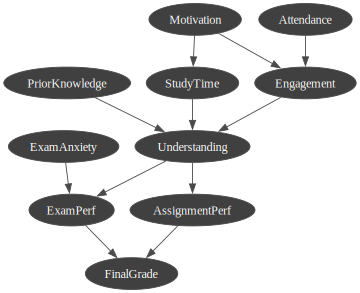

In [49]:
# Display interactive SVG in the notebook
gnb.showBN(bn)

In [50]:
# # Generates data
# # Assuming 'bn' is your Bayesian network
# generator = gum.BNDatabaseGenerator(bn)
# nr = 10000  #fill in the amount of datasameples you want. We filled in 100, 500, 1000 and 10000
# generator.drawSamples(nr)
# df = generator.to_pandas()

# # Save it to a CSV file
# df.to_csv(f'data_sample_{nr}.csv', index=False)

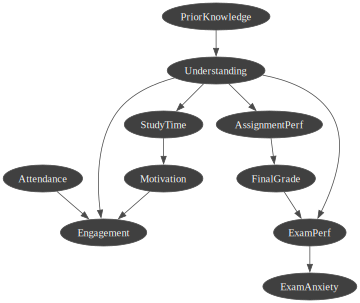

hamming: {'hamming': 0, 'structural hamming': 7}


In [51]:
df_MIIC = pd.read_csv("data_sample_1000.csv")

# ----- Structure Learning -----
# When learning the structure, simply pass the dataframe to BNLearner.
bn_MIIC = gum.BNLearner(df_MIIC)

# Instruct the learner to use the MIIC algorithm.
bn_MIIC.useMIIC() 

# Learn the structure of the BN.
bn_structure_MIIC = bn_MIIC.learnBN()

# Display the interactive graph of the learned Bayesian network
gnb.showBN(bn_structure_MIIC)

# 6. Compute Structural Hamming Distance
cmp = gcm.GraphicalBNComparator(bn, bn_structure_MIIC)
print("hamming:", cmp.hamming())
# gnb.showBNDiff(expert_bn, learned_bn)
gnb.flow.add(gnb.getBNDiff(bn, bn_structure_MIIC, size="8!"), "manual bn vs learned bn")
gnb.flow.add(gcm.graphDiffLegend())
gnb.flow.display()

Learned BN Structure:
BN{nodes: 10, arcs: 14, domainSize: 2048, dim: 37, mem: 528o}


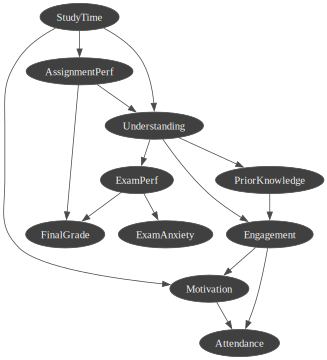

hamming: {'hamming': 3, 'structural hamming': 12}


In [52]:
df_GHC = pd.read_csv("data_sample_1000.csv")

# ----- Structure Learning -----
# When learning the structure, simply pass the dataframe to BNLearner.
bn_GHC = gum.BNLearner(df_GHC)

# Instruct the learner to use the MIIC algorithm.
bn_GHC.useGreedyHillClimbing()

# Learn the structure of the BN.
bn_structure_GHC = bn_GHC.learnBN()
print("Learned BN Structure:")
print(bn_structure_GHC)

# Display the interactive graph of the learned Bayesian network
gnb.showBN(bn_structure_GHC)

# 6. Compute Structural Hamming Distance
cmp = gcm.GraphicalBNComparator(bn, bn_structure_GHC)
print("hamming:", cmp.hamming())
# gnb.showBNDiff(expert_bn, learned_bn)
gnb.flow.add(gnb.getBNDiff(bn, bn_structure_GHC, size="8!"), "manual bn vs learned bn")
gnb.flow.add(gcm.graphDiffLegend())
gnb.flow.display()

# Question 2,3,4 start here

In [53]:
# 1. Load expert BN from bc.net
expert_bn = gum.loadBN("bc.net")

# 2. Read your data
df_med = pd.read_csv("bc.csv")

# 3. Instantiate the learner on your DataFrame
learner = gum.BNLearner(df_med)

# 4. Tell the learner to use Greedy Hill-Climbing
learner.useGreedyHillClimbing()#.useNMLCorrection().useScoreBDeu()

# 5. Trigger the structure learning and get back a BayesianNetwork
learned_bn = learner.learnBN()

# 6. Compute Structural Hamming Distance
cmp = gcm.GraphicalBNComparator(expert_bn, learned_bn)
print("hamming:", cmp.hamming())

hamming: {'hamming': 4, 'structural hamming': 17}


In [54]:
gum.loadBN("bc.net")

(pyagrum.BayesNet@000001E1B8C28FE0) BN{nodes: 16, arcs: 18, domainSize: 10^6.42393, dim: 106, mem: 1Ko 360o}

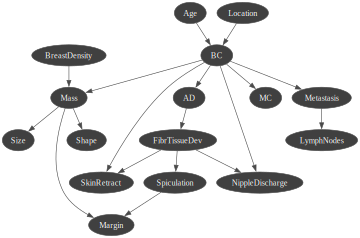

In [55]:
gnb.showBN(expert_bn)

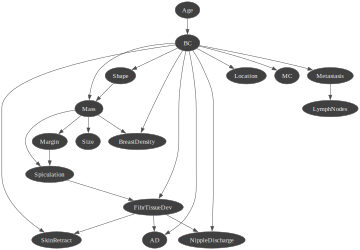

In [56]:
gnb.showBN(learned_bn)

In [57]:
# gnb.showBNDiff(expert_bn, learned_bn)
gnb.flow.add(gnb.getBNDiff(expert_bn, learned_bn, size="8!"), "Provided BN vs GHC Learned BN")
gnb.flow.add(gcm.graphDiffLegend())

gnb.flow.display()

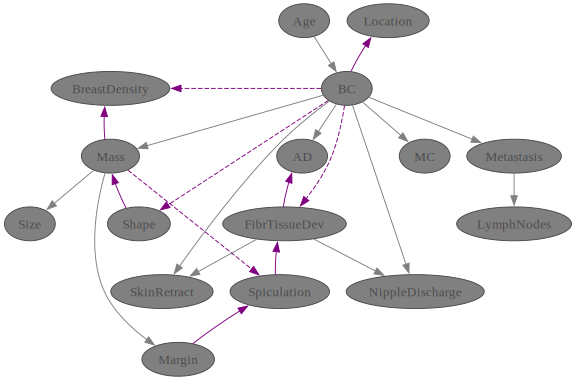

In [58]:
# showBNDiff itself will add & render the diff
gnb.showBNDiff(
    expert_bn,
    learned_bn,
    size="8!",
)



In [59]:
print(learned_bn["BC"])

BC:Labelized({Insitu|Invasive|No})


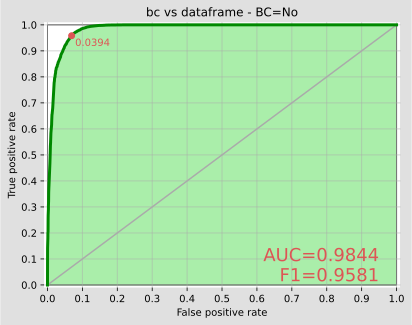

In [60]:
showROC(expert_bn, df_med, "BC", "No", show_progress=False)

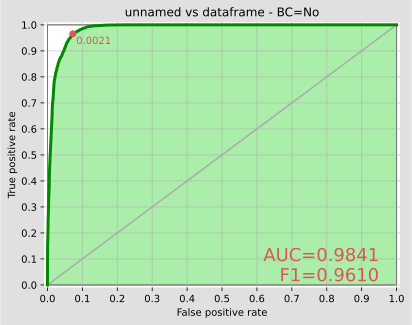

In [61]:
showROC(learned_bn, df_med, "BC", "No", show_progress=False)

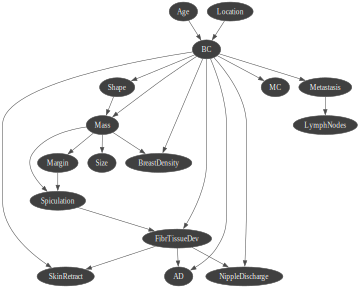

hamming: {'hamming': 4, 'structural hamming': 9}


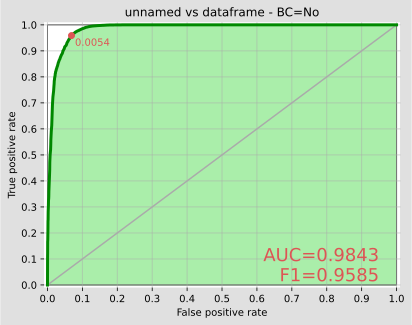

In [62]:
# Create learner from data (file or DataFrame)
learner = gum.BNLearner(df_med)

# Choose algorithm
learner.useGreedyHillClimbing()

# # Apply constraints
learner.addMandatoryArc("Location", "BC")
learner.addMandatoryArc("Age", "BC")    # force an arc

# Learn the BN
guided_bn_arc = learner.learnBN()

# Visualise
gnb.show(guided_bn_arc)

# 6. Compute Structural Hamming Distance
cmp = gcm.GraphicalBNComparator(expert_bn, guided_bn_arc)
print("hamming:", cmp.hamming())

# gnb.showBNDiff(expert_bn, learned_bn)
gnb.flow.add(gnb.getBNDiff(expert_bn, guided_bn_arc, size="8!"), "Difference ")
gnb.flow.add(gcm.graphDiffLegend())
gnb.flow.display()
showROC(guided_bn_arc, df_med, "BC", "No", show_progress=False)

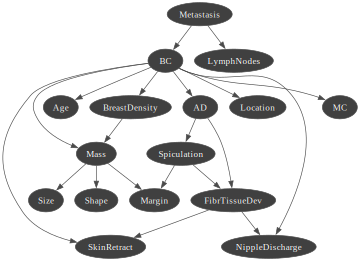

hamming: {'hamming': 4, 'structural hamming': 9}


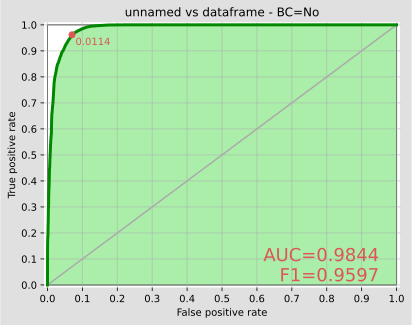

In [63]:
# Create learner from data (file or DataFrame)
learner = gum.BNLearner(df_med, expert_bn)

# Choose algorithm
learner.useGreedyHillClimbing()

# # Apply constraints
# learner.addMandatoryArc("Location", "BC")
# learner.addMandatoryArc("Age", "BC")    # force an arc

# Learn the BN
guided_bn = learner.learnBN()

# Visualise
gnb.show(guided_bn)

# 6. Compute Structural Hamming Distance
cmp = gcm.GraphicalBNComparator(expert_bn, guided_bn_arc)
print("hamming:", cmp.hamming())

# gnb.showBNDiff(expert_bn, learned_bn)
gnb.flow.add(gnb.getBNDiff(expert_bn, guided_bn_arc, size="8!"), "Difference ")
gnb.flow.add(gcm.graphDiffLegend())
gnb.flow.display()
showROC(guided_bn, df_med, "BC", "No", show_progress=False)
